# Proposed implementation of metrics involving leadership, maintainers
In this document, I propose a solution to the problem of collecting data related to maintainers or in general, leadership. Here, I tackle two chaoss metrics related to maintainer data: *New Contributors vs Maintainers*, and *Change in Maintainer Number* from https://github.com/chaoss/metrics/blob/master/1_Diversity-Inclusion.md.
1. *New Contributors vs Maintainers* means Ratio of new contributors to maintainers over time.
2. *Change in Maintainer number* means Number of maintainers added/removed over time.

### The problem
Although the members of a repo can be obtained through the Github api, the exact dates when they were appointed cannot be known. Hence the comparison over time cannot be made. On top of that, when speaking of leadership in general, a project of an organisation can have other people like Board members, non-technical people etc, who may have never contributed to the code but are a part of the project, so these information also cannot be obtained from repositories directly.

### Solution
Therefore, as a solution, I propose that these information regarding leadership be obtained manually through input files. However, this time the file format will be `json` because the structure of the required data conforms to the *key:value* format, as explained in the next section.

The number of new contributors for *New Contributors vs Maintainers* can be obtained in a similar way as in Microtask1, and the number of maintainer are obtained from the JSON file, whose ratio can then be plotted.

The files that I use here are: *sample_new_contributors.csv* containing number of new contributors month wise (obtained from Microtask1), and *leadership.json* is a file written by me as a sample.

### The JSON file format
```
{
    "maintainers": {
         "2015-08-15": {
             "name": "ABC",
             "gender": "M",
             "age": "23",
             "education": "masters",
             "action": "added"
          },
          "2017-05-20": {
             "name": "ABC",
             "gender": "M",
             "age": "23",
             "education": "masters",
             "action": "deleted"
          },
          "date3": {
             "name": "<value>",
             "gender": "M/F/T",
             "age": "<value>",
             "education": "<value>",
             "action": "added"
          },
          ..................
    },
    "board": {
        "date1": {
             "name": "<value>",
             "gender": "M/F/T",
             "age": "<value>",
             "education": "<value>",
             "action": "added"
          },
          "date2": {
             "name": "<value>",
             "gender": "M/F/T",
             "age": "<value>",
             "education": "<value>",
             "action": "deleted"
          }
          ..................
            
    },
    "others": {
        "date1": {
             ...................
          }
          ..................
    }
}
```
The file has leadership categories like `maintainers`,`board` members and other categories as top-level keys. Under that, the date when the members were added/removed, form the next-level keys, whose value consist of the details of the member as a dict. First, we identify the category of leadership, then the date and then we get the member details. For example, a leadership member, who is a `maintainer` was added on `15-08-2015` has name `ABC`,age `23` and so on. Notice the `action` field which can have two values: *added* or *deleted*. So when iterating over the maintainers we first come across the date `15-08-2015` when `ABC` was added and then we come across `20-05-2017` when `ABC` was removed hence action has value `deleted`. So this structure will allow us to keep track of the time as well as addition/removal of members and, hence makes a comparative study over time possible. 

The other fields like `age`,`education`,`gender` will allow us to make a demographic comparison as we did in *Contributor demographics* metric notebook. So we cover the metrics `Leadership Demographics`, `Change in Maintainer Number` from this JSON file. The JSON file is flexible, and can be modified to include other fields, when required.

# Sample Code
First we import the required modules

In [1]:
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt

This functions calculates and then plots the new_contributor_vs_maintainer metric. At first it reads both the files, then puts the number of new contributors per months into `buckets` where `buckets` is a dictionary and is keyed on `month`, that is, for each month, `buckets` stores the number of new contributors, and the number of maintainers present. This information can be later used to calculate the ratio which we ultimately plot.

In [2]:
def new_contributor_vs_maintainer(csv_filename, json_filename):
    new_contributors = pd.read_csv(csv_filename)
    maintainers = json.load(open(json_filename))
    buckets = {}
    
    # put the new contributors information into respective buckets
    for _,row in new_contributors.iterrows():
        month = row['Month']
        number = row['Number of new commiters']
        buckets[month] = {'contrib':number, 'maintainer': 0}

    # calculate number of maintainers
    maintainers = maintainers['maintainers']
    maintainer_count = 0
    for each in maintainers.keys():
        date = datetime.datetime.strptime(each,'%Y-%m-%d')
        date = datetime.datetime.strftime(date,'%B-%Y')
        if maintainers[each]['action'] == 'added':
            maintainer_count += 1
        elif maintainers[each]['action'] == 'deleted':
            maintainer_count -= 1

        # if the date or month is not already in `buckets` dict,
        # then it means that no new contributors came in during that month
        # so put number of contributors as 0 and calculated maintainer number for that month
        if date not in buckets:
            buckets[date] = {
                'contrib':0,
                'maintainer': maintainer_count
            }
        else: 
            buckets[date]['maintainer'] += maintainer_count
    
    # after the previous step,
    # the number of maintainers for the month when no new maintainers were added/removed is zero
    # but it should be equal to the number of maintainers already present that is equal to the 
    # number, when maintainers list was last updated
    last_seen = 0
    for each in buckets.keys():
        hold_count = buckets[each]['maintainer']
        if hold_count > 0:
            last_seen = hold_count
        buckets[each]['maintainer'] = last_seen
        
    # sort the dictionary according to months
    buckets = dict(sorted(buckets.items(), key = lambda x: datetime.datetime.strptime(x[0], '%B-%Y')))
    print(buckets)
    
    # extracting x and y coordinates for the plot, calculate ratio
    x = buckets.keys()
    y_ratio = []
    for k in buckets.keys():
        y_ratio += [buckets[k]['contrib'] / buckets[k]['maintainer']]
    plot(x, y_ratio, 'New contributor vs maintainer ratio', 'b', 'o', 'upper center', 
         "Ratio of new contributors to maintainers over time")

Similar to calculating number of maintainers section of the above metric code.

In [3]:
def change_in_maintainer_number(json_filename):
    maintainers = json.load(open(json_filename))
    buckets = {}
   
    maintainers = maintainers['maintainers']
    maintainer_count = 0
    for each in maintainers.keys():
        date = datetime.datetime.strptime(each,'%Y-%m-%d')
        date = datetime.datetime.strftime(date,'%B-%Y')
        if maintainers[each]['action'] == 'added':
            maintainer_count += 1
        elif maintainers[each]['action'] == 'deleted':
            maintainer_count -= 1

        if date not in buckets:
            buckets[date] = {
                'maintainer': maintainer_count
            }
        else: 
            buckets[date]['maintainer'] += maintainer_count

    last_seen = 0
    for each in buckets.keys():
        hold_count = buckets[each]['maintainer']
        if hold_count > 0:
            last_seen = hold_count
        buckets[each]['maintainer'] = last_seen
    buckets = dict(sorted(buckets.items(), key = lambda x: datetime.datetime.strptime(x[0], '%B-%Y')))
    print()
    print(buckets)
    
    # extracting x and y coordinates for the plot
    x = buckets.keys()
    y_maintainer = []
    for k in buckets.keys():
        y_maintainer += [buckets[k]['maintainer']]
        
    plot(x, y_maintainer, 'Number of maintainers', 'b', 'o', 'upper center',
        "Change in maintainer number over time")

A generic plot function which when given X,Y coordinate values and other parameters plots a graph.
This can be made more generic by passing the number of subplots we want, and looping those number of times to create subplots. We can also define functions for pie-chart, line-chart, etc and choose which graph to plot depending on a passed parameter.

In [4]:
def plot(X, Y, label, color, marker, loc, title):
    fig = plt.figure(figsize = (20,8))
    fig.suptitle("Contributor, maintainer metrics",fontsize=28)
    
    ax = fig.add_subplot(111)
    ax.plot(X, Y, label=label, color=color, marker=marker)
    plt.xticks(rotation=70)
    plt.title(title, fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=loc, bbox_to_anchor=(1,1))
    ax.grid(True)

The diversity_inclusion_metric() function is called once and it will compute all the metrics falling under it one by one. We can also see that depending on the parameters passed, we can decide which metric, falling under the category *diversity_inclusion*, will be computed. For example, if `csv_filename` is not provided then *new_contributor_vs_maintainer()* will not be called, that is, this metric will not be computed.

In [5]:
def diversity_inclusion_metric(csv_filename = None, json_filename = None):
    if csv_filename and json_filename:
        new_contributor_vs_maintainer(csv_filename, json_filename)
    if json_filename:
        change_in_maintainer_number(json_filename)

{'August-2015': {'contrib': 1, 'maintainer': 1}, 'September-2015': {'contrib': 2, 'maintainer': 1}, 'October-2015': {'contrib': 1, 'maintainer': 1}, 'November-2015': {'contrib': 1, 'maintainer': 1}, 'December-2015': {'contrib': 3, 'maintainer': 2}, 'January-2016': {'contrib': 1, 'maintainer': 2}, 'March-2016': {'contrib': 4, 'maintainer': 3}, 'April-2016': {'contrib': 5, 'maintainer': 3}, 'May-2016': {'contrib': 2, 'maintainer': 3}, 'June-2016': {'contrib': 12, 'maintainer': 3}, 'July-2016': {'contrib': 11, 'maintainer': 3}, 'August-2016': {'contrib': 13, 'maintainer': 4}, 'September-2016': {'contrib': 3, 'maintainer': 4}, 'October-2016': {'contrib': 8, 'maintainer': 5}, 'November-2016': {'contrib': 7, 'maintainer': 5}, 'December-2016': {'contrib': 1, 'maintainer': 4}, 'January-2017': {'contrib': 1, 'maintainer': 4}, 'February-2017': {'contrib': 5, 'maintainer': 4}, 'March-2017': {'contrib': 24, 'maintainer': 4}, 'April-2017': {'contrib': 5, 'maintainer': 4}, 'May-2017': {'contrib': 16

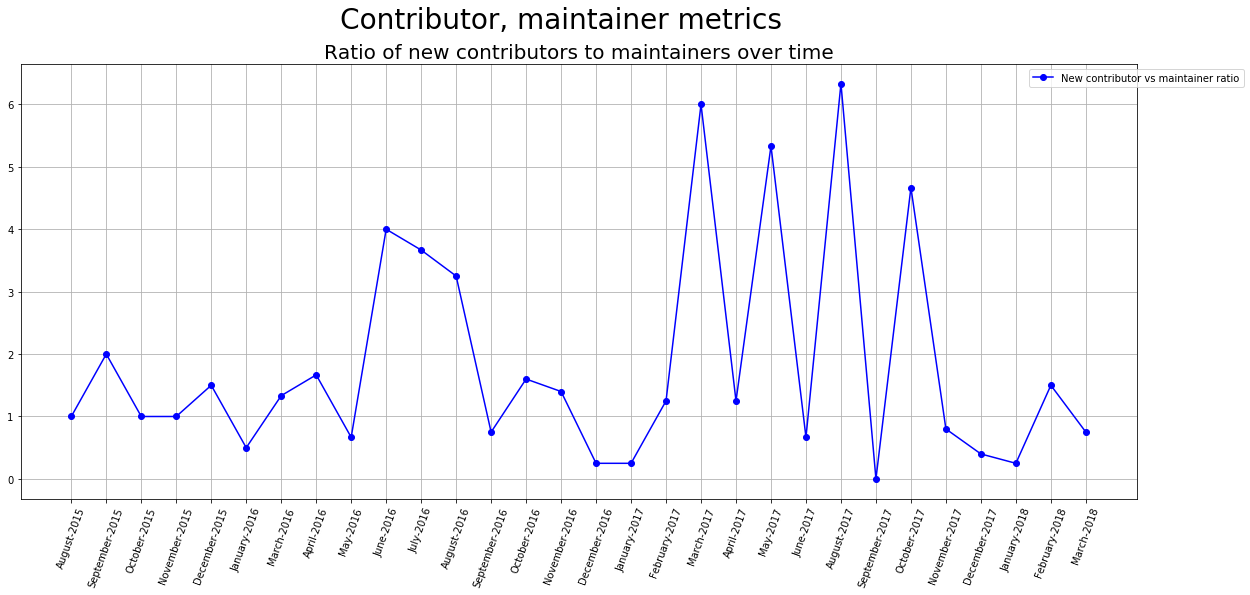

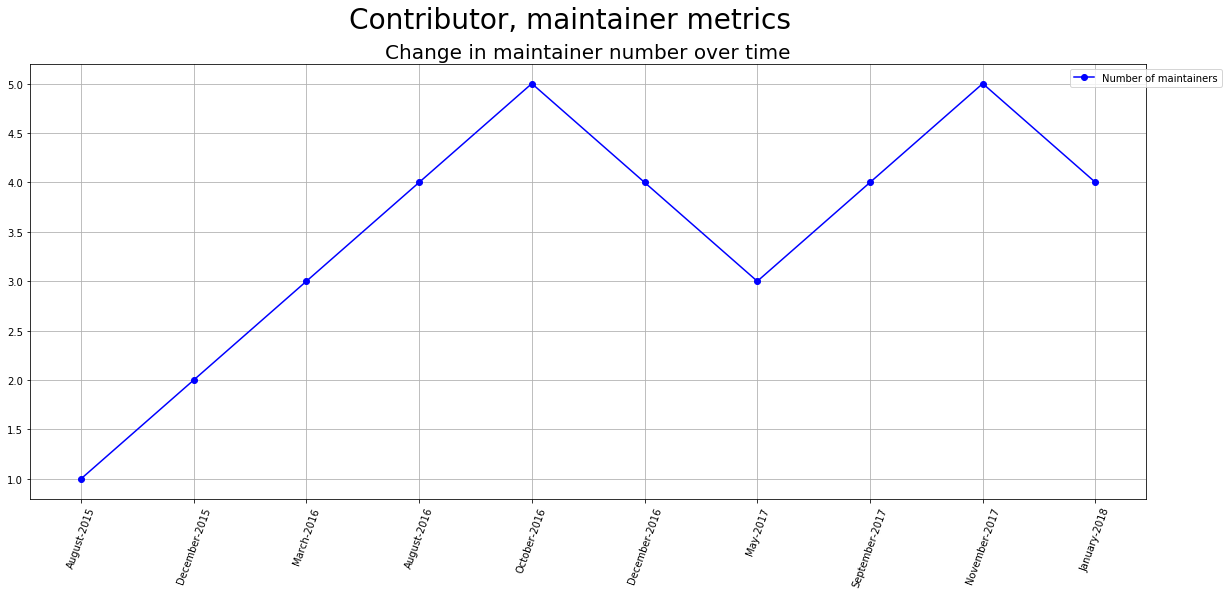

In [6]:
diversity_inclusion_metric('sample_new_contributors.csv', 'leadership.json')